In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
from iexfinance.stocks import get_historical_data
import iexfinance as iex

In [4]:
list_of_tickers = ["SPY", "AGG"]
weights = [.4, .6]

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [5]:
import pickle
'''
historical_df = get_historical_data(list_of_tickers, 
                         output_format='pandas', 
                         start='2019-01-01', 
                         end='2019-12-31', 
                         close_only=True, volume=False)
historical_df.to_pickle("./SpyAggHistorical")
'''
stocks_close_df = pd.read_pickle("./SpyAggHistorical")
stocks_close_df.drop(columns=['volume'], level=1, inplace=True)
stocks_close_df.columns = stocks_close_df.columns.droplevel(1)
stocks_close_df.sort_index(ascending = True, inplace = True)

# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [6]:
# Calculate the daily roi for the stocks
daily_returns_df = stocks_close_df.pct_change().dropna()
mean_returns = daily_returns_df.mean()

In [7]:
# Calculate volatility
spy_daily_std = daily_returns_df.std()['SPY']
agg_daily_std = daily_returns_df.std()['AGG']

In [8]:
# Save the last day's closing price
lastday_close = stocks_close_df.iloc[-1]

In [13]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()
sim_df = pd.DataFrame()
portfolio_cum_returns = pd.DataFrame()

In [10]:
%%time 
# Run the Monte Carlo Simulation
for x in range(number_simulations):  
    
    sim_spy_prices = [lastday_close[0]]
    sim_agg_prices = [lastday_close[1]]

    for n in range(number_records):
        
        sim_spy_price = sim_spy_prices[-1] * (1 + np.random.normal(mean_returns[0], spy_daily_std))
        sim_agg_price = sim_agg_prices[-1] * (1 + np.random.normal(mean_returns[1], agg_daily_std))
        
        sim_spy_prices.append(sim_spy_price)
        sim_agg_prices.append(sim_agg_price)
        
    sim_df['SPY'] = pd.Series(sim_spy_prices)
    sim_df['AGG'] = pd.Series(sim_agg_prices)
    
    sim_daily_returns = sim_df.pct_change()
    
    portfolio_daily_returns = sim_daily_returns.dot(weights)
    
    portfolio_cum_returns[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
# portfolio_returns = spy_sim_price * .6 + agg_sim_price * .4
# portfolio30years = np.cumprod(portfolio_returns + 1, axis = 0)
# portfolio30years_simulation = pd.DataFrame(portfolio30years)
# portfolio30years_simulation.tail()

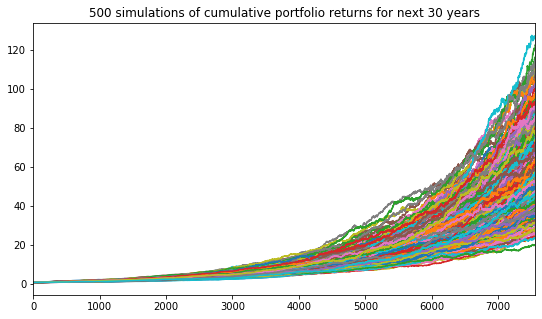

In [18]:
# Visualize the Simulation
portfolio_cum_returns.plot(legend=None,
                          title='500 simulations of cumulative portfolio returns for next 30 years',
                          figsize=(9,5))
plt.savefig("./images/simulation.png")

In [46]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
last_cum_returns30 = portfolio_cum_returns.iloc[-1]

In [45]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
last_cum_returns20 = portfolio_cum_returns.iloc[252*20-1]

In [47]:
# Display the 90% confidence interval for the ending returns
quantile_result = last_cum_returns30.quantile(q=[.05, .95])
print(f"90% confidence interval of 30 year ending price for 60/40 investment in portfolio \
is between ${int(quantile_result[.05])} and ${int(quantile_result[.95])}.")

90% confidence interval of 30 year ending price for 60/40 investment in portfolio is between $33 and $91.


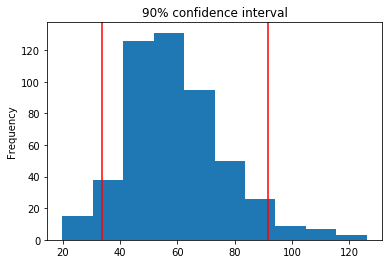

In [44]:
# Visualize the distribution of the ending returns
last_cum_returns30.plot(kind = 'hist', title="90% confidence interval")
plt.axvline(quantile_result.iloc[0], color='r')
plt.axvline(quantile_result.iloc[1], color='r')
plt.savefig("./images/confidence_level.png")

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [59]:
quantile_10_50_90 = last_cum_returns30.quantile(q = [.10, .50, .90])
print(quantile_10_50_90)

0.1    40.573985
0.5    57.086108
0.9    81.604234
Name: 7560, dtype: float64
0.5    57.086108
0.5    57.086108
Name: 7560, dtype: float64


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [60]:
initial_investment = 20000
returns_10_50_90 = (quantile_10_50_90*initial_investment).astype(int)
print(returns_10_50_90)

0.1     811479
0.5    1141722
0.9    1632084
Name: 7560, dtype: int64


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [ ]:
# YOUR CODE HERE

### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [ ]:
# YOUR CODE HERE

### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# YOUR CODE HERE